In [1]:
from linares_plot import *
import scipy.io as io
import pickle
from scipy.ndimage import gaussian_filter
from scipy import misc

In [2]:
def decode_rE(rE, a_ini=0, a_fin=360, N=512):
    #Population vector for a given rE
    # return ( angle in radians, absolut angle in radians, abs angle in degrees )
    N=len(rE)
    Angles = np.linspace(a_ini, a_fin, N) 
    angles=np.radians(Angles)
    rE = np.reshape(rE, (1,N))
    R = np.sum(np.dot(rE,np.exp(1j*angles)))/np.sum(rE)
    
    angle_decoded = np.degrees(np.angle(R))
    if angle_decoded<0:
        angle_decoded = 360+angle_decoded
    
    return angle_decoded


def err_deg(a1,ref):
    ### Calculate the error ref-a1 in an efficient way in the circular space
    ### "going ccw from the reference (ref) is negative" - "going cw from the reference (ref) is positive"
    ### it uses complex numbers!
    ### Input in degrees (0-360)
    a1=np.radians(a1)
    ref=np.radians(ref)
    err = np.angle(np.exp(1j*ref)/np.exp(1j*(a1) ), deg=True) 
    err=round(err, 2)
    return err


In [ ]:
simulation_20481_1630677787_oxigen.mat        gEEA=533.3   IEX=0     pos=180

simulation_20669_1630678558_oxigen.mat        gEEA=525.0   IEX=0     pos=180

simulation_20750_1630679020_oxigen.mat        gEEA=500.0   IEX=0     pos=180

simulation_20823_1630679458_oxigen.mat        gEEA=450.0   IEX=0     pos=180

simulation_20981_1630679817_oxigen.mat        gEEA=475.0   IEX=0     pos=180

simulation_21120_1630680211_oxigen.mat        gEEA=490.0   IEX=0     pos=180

simulation_21222_1630680709_oxigen.mat        gEEA=490.0   IEX 1     pos=180

simulation_21359_1630681677_oxigen.mat        gEEA=480.0   IEX=0     pos=180

simulation_21596_1630682807_oxigen.mat        gEEA=475.0   IEX=0.5   pos=90

simulation_21673_1630683291_oxigen.mat        gEEA=475.0   IEX=0     pos=90

simulation_21863_1630684245_oxigen.mat        gEEA=477.0   IEX=0     pos=90

##########   simulation_21504_1630682192_oxigen.mat        gEEA=480.0   IEX=0     pos=90

##########   simulation_22199_1630685437_oxigen.mat        gEEA=480.0   IEX=0.5     pos=90

simulation_19842_1630937830_nitrogen.mat      gEEA=490.0   IEX=0.5    pos=90

simulation_4638_1631009192_oxigen.mat         gEEA=485.0   IEX=0.5    pos=90


In [127]:
## OFF

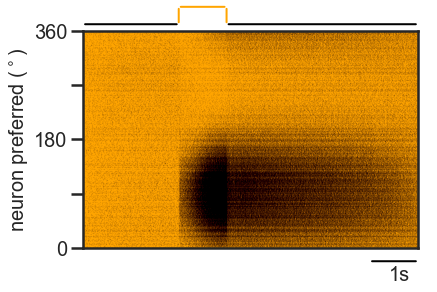

In [137]:
%matplotlib inline

data = io.loadmat('C:\\Users\\David\\Desktop\\IDIBAPS\\brian_simulations\\simulation_21504_1630682192_oxigen.mat') #,{'rate':rates, 'spktm': spikes.it})
spikes = data['spktm']
rates= data['ratedelay']

N0 = 20000
time_s =7
N=0.8*N0 #(el 80% son excitadoras)
stim_on=2
stim_off=3


fig, ax = plt.subplots()
ax.plot(spikes[1],spikes[0], '.', markersize=0.03, color='black')
ax.set_facecolor("orange")
plt.xlim(0,time_s)
plt.ylim(0,N)

# ax = fig.add_subplot(1, 1, 1)
inf=1.03
sup=1.11
ax.annotate('', xy=(0, inf), xycoords='axes fraction', xytext=(stim_on/time_s, inf), arrowprops=dict(arrowstyle="-", color='black'))
ax.annotate('', xy=(stim_on/time_s, inf), xycoords='axes fraction', xytext=(stim_on/time_s, sup), arrowprops=dict(arrowstyle="-", color='orange'))
ax.annotate('', xy=(stim_on/time_s, sup), xycoords='axes fraction', xytext=(stim_off/time_s, sup), arrowprops=dict(arrowstyle="-", color='orange'))
ax.annotate('', xy=(stim_off/time_s, sup), xycoords='axes fraction', xytext=(stim_off/time_s, inf), arrowprops=dict(arrowstyle="-", color='orange'))
ax.annotate('', xy=(stim_off/time_s, inf), xycoords='axes fraction', xytext=(1, inf), arrowprops=dict(arrowstyle="-", color='black'))

ax.annotate('', xy=(1-1/time_s, -.06), xycoords='axes fraction', xytext=(1, -.06), arrowprops=dict(arrowstyle="-", color='black'))
plt.text(time_s-0.6, -0.15*N, '1s', fontsize=20) ##en función de time_s y N
plt.gca().set_xticks([])
plt.gca().set_xticklabels([])

plt.gca().set_yticks([0, int(N/4), int(N/2),  int(3*N/4), int(N) ])
plt.gca().set_yticklabels(['0','','180', '', '360'], fontsize=20)
plt.gca().set_ylabel('neuron preferred ($^\circ$)', fontsize=20);

plt.show()

In [138]:
time_s =7000 #(ms)
rounding = 2 ##round the timing
w=100 #(ms)


pos_stim = 360*data['pos_stim'][0][0]
Iext = data['IEext'][0][0]


spikes = data['spktm']

Matrix_spikes=np.zeros([int(0.8*N0), time_s])

neurons_ = np.array([int(spikes[0][x]) for x in range(len(spikes[0]))])

times_ = np.array([spikes[1][x] for x in range(len(spikes[1]))])
times_ = times_ - min(times_)
times_ = np.array([int(times_[x]*1000) for x in range(len(times_))])

# dimensions = neurons, time_s
for t, n in zip(times_, neurons_ ):
    Matrix_spikes[n,t]=1
##
####
#### STEP 2: calculate firing of each neuron in windows of 100ms (10)
####
t1s = np.arange(0, time_s ,w)
t2s = np.arange(w, time_s+w, w)
##
fr_time = []
for N in range(np.shape(Matrix_spikes)[0]):
    neuron_fr = []
    for i in range(len(t1s)):
        neuron_fr.append(Matrix_spikes[N, t1s[i]:t2s[i]].sum()/ float(1000/w) ) 
    #
    fr_time.append(neuron_fr)
###
fr_time=np.array(fr_time)

In [139]:
firings_wind_final_OFF=fr_time[:,-1]
target_ = pos_stim
decoded_position = decode_rE(firings_wind_final_OFF, N=16000)
Error = err_deg(decoded_position, target_)
print( 'Error OFF: ' +str(Error))

target_pos = np.linspace(0,360,16000) 

target_pos = np.array([int(target_pos[x]) for x in range(len(target_pos))])
position_center_bump =   target_pos[np.where(firings_wind_final_OFF==max(firings_wind_final_OFF))[0][0]]
fract = position_center_bump/360
to_move = - ( int(round(0.5*N,0)) - int(round(fract*N,0))  )

target_pos = np.roll(target_pos, to_move) 
target_pos = target_pos -180

df_OFF = pd.DataFrame({'rate': firings_wind_final_OFF, 'preferred':target_pos })
df_OFF['stimulation']='OFF'


Error OFF: 9.65


In [131]:
### ON

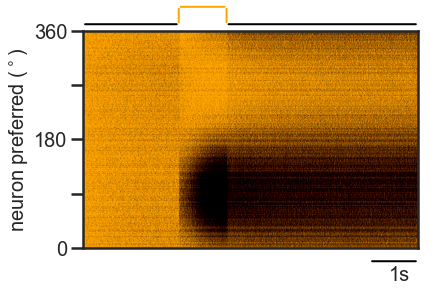

In [140]:
%matplotlib inline

data = io.loadmat('C:\\Users\\David\\Desktop\\IDIBAPS\\brian_simulations\\simulation_4638_1631009192_oxigen.mat') #,{'rate':rates, 'spktm': spikes.it})
spikes = data['spktm']
rates= data['ratedelay']

N0 = 20000
time_s =7
N=0.8*N0 #(el 80% son excitadoras)
stim_on=2
stim_off=3


fig, ax = plt.subplots()
ax.plot(spikes[1],spikes[0], '.', markersize=0.03, color='black')
ax.set_facecolor("orange")
plt.xlim(0,time_s)
plt.ylim(0,N)

# ax = fig.add_subplot(1, 1, 1)
inf=1.03
sup=1.11
ax.annotate('', xy=(0, inf), xycoords='axes fraction', xytext=(stim_on/time_s, inf), arrowprops=dict(arrowstyle="-", color='black'))
ax.annotate('', xy=(stim_on/time_s, inf), xycoords='axes fraction', xytext=(stim_on/time_s, sup), arrowprops=dict(arrowstyle="-", color='orange'))
ax.annotate('', xy=(stim_on/time_s, sup), xycoords='axes fraction', xytext=(stim_off/time_s, sup), arrowprops=dict(arrowstyle="-", color='orange'))
ax.annotate('', xy=(stim_off/time_s, sup), xycoords='axes fraction', xytext=(stim_off/time_s, inf), arrowprops=dict(arrowstyle="-", color='orange'))
ax.annotate('', xy=(stim_off/time_s, inf), xycoords='axes fraction', xytext=(1, inf), arrowprops=dict(arrowstyle="-", color='black'))

ax.annotate('', xy=(1-1/time_s, -.06), xycoords='axes fraction', xytext=(1, -.06), arrowprops=dict(arrowstyle="-", color='black'))
plt.text(time_s-0.6, -0.15*N, '1s', fontsize=20) ##en función de time_s y N
plt.gca().set_xticks([])
plt.gca().set_xticklabels([])

plt.gca().set_yticks([0, int(N/4), int(N/2),  int(3*N/4), int(N) ])
plt.gca().set_yticklabels(['0','','180', '', '360'], fontsize=20)
plt.gca().set_ylabel('neuron preferred ($^\circ$)', fontsize=20);

plt.show()

In [141]:
time_s =7000 #(ms)
rounding = 2 ##round the timing
w=100 #(ms)


pos_stim = 360*data['pos_stim'][0][0]
Iext = data['IEext'][0][0]


spikes = data['spktm']

Matrix_spikes=np.zeros([int(0.8*N0), time_s])

neurons_ = np.array([int(spikes[0][x]) for x in range(len(spikes[0]))])

times_ = np.array([spikes[1][x] for x in range(len(spikes[1]))])
times_ = times_ - min(times_)
times_ = np.array([int(times_[x]*1000) for x in range(len(times_))])

# dimensions = neurons, time_s
for t, n in zip(times_, neurons_ ):
    Matrix_spikes[n,t]=1
##
####
#### STEP 2: calculate firing of each neuron in windows of 100ms (10)
####
t1s = np.arange(0, time_s ,w)
t2s = np.arange(w, time_s+w, w)
##
fr_time = []
for N in range(np.shape(Matrix_spikes)[0]):
    neuron_fr = []
    for i in range(len(t1s)):
        neuron_fr.append(Matrix_spikes[N, t1s[i]:t2s[i]].sum()/ float(1000/w) ) 
    #
    fr_time.append(neuron_fr)
###
fr_time=np.array(fr_time)

In [142]:
firings_wind_final_ON=fr_time[:,-1]
target_ = pos_stim
decoded_position = decode_rE(firings_wind_final_ON, N=16000)
Error = err_deg(decoded_position, target_)
print( 'Error ON: ' +str(Error))

target_pos = np.linspace(0,360,16000)

target_pos = np.array([int(target_pos[x]) for x in range(len(target_pos))])
position_center_bump =   target_pos[np.where(firings_wind_final_ON==max(firings_wind_final_ON))[0][0]]
fract = position_center_bump/360
to_move = - ( int(round(0.5*N,0)) - int(round(fract*N,0))  )

target_pos = np.roll(target_pos, to_move) 
target_pos = target_pos -180

df_ON = pd.DataFrame({'rate': firings_wind_final_ON, 'preferred':target_pos })
df_ON['stimulation']='ON'

Error ON: -4.58


In [135]:
## Plot

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


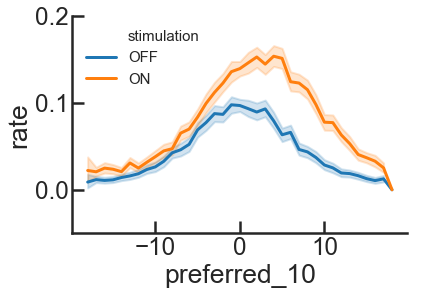

In [136]:
#490
df_ = pd.concat([df_OFF, df_ON])
df_['preferred_10'] = [int(df_['preferred'].values[x]/10) for x in range(len(df_)) ]
sns.lineplot(x='preferred_10', y='rate', hue='stimulation', data=df_)
plt.legend(frameon=False, fontsize=15)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.ylim(-0.05, 0.2);

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


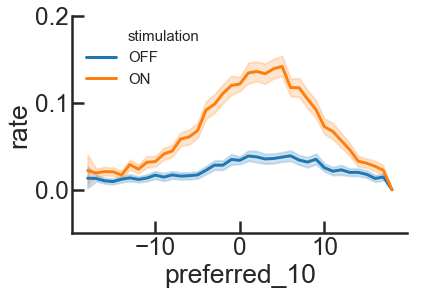

In [143]:
#480
df_ = pd.concat([df_OFF, df_ON])
df_['preferred_10'] = [int(df_['preferred'].values[x]/10) for x in range(len(df_)) ]
sns.lineplot(x='preferred_10', y='rate', hue='stimulation', data=df_)
plt.legend(frameon=False, fontsize=15)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.ylim(-0.05, 0.2);